# Relationship of filter inference to summary statistics-based ABC 

In [5]:
import os

import chi
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
sns.set_theme()

from exponential_growth_model import ExponentialGrowthModel

For the cancer growth model we used Gaussian filters, which are constructed from
the estimated mean and variance of the simulated measurements. Let us compare
the distribution of accepted means and variances for different dataset sizes.

## Plot accepted means and variances for varying dataset sizes at t=0.6

### Import data

In [35]:
# Import Cancer modelling results
directory = os.getcwd()
measurements = []
cancer_results = []
measurements.append(
    pd.read_csv(
        directory + '/data/1_cancer_growth_data_15.csv')
)
cancer_results.append(
    xr.load_dataset(
        directory +
        '/posteriors/' +
        '2_filter_inference_cancer_growth_15.nc')
)
measurements.append(
    pd.read_csv(
        directory + '/data/1_cancer_growth_data_45.csv')
)
cancer_results.append(
    xr.load_dataset(
        directory +
        '/posteriors/' +
        '3_filter_inference_cancer_growth_45.nc')
)
measurements.append(
    pd.read_csv(
        directory + '/data/1_cancer_growth_data_135.csv')
)
cancer_results.append(
    xr.load_dataset(
        directory +
        '/posteriors/' +
        '4_filter_inference_cancer_growth_135.nc')
)
measurements.append(
    pd.read_csv(
        directory + '/data/1_cancer_growth_data_405.csv')
)
cancer_results.append(
    xr.load_dataset(
        directory +
        '/posteriors/' +
        '5_filter_inference_cancer_growth_405.nc')
)

### Compute means and variances

In [110]:
## Compute means and variances of data
time = 0.6
data_summary_stats = []
for data in measurements:
    mask = data.Time == time
    data = data[mask]
    data_summary_stats.append([
        np.mean(data.Value.values),
        np.var(data.Value.values, ddof=1)
    ])

# Define mechanistic model
model = ExponentialGrowthModel()

inference_summary_stats = []
for results in cancer_results:
    # Collect parameters of individuals across iterations
    parameters = np.vstack((
        results['Initial count'].values,
        results['Growth rate'].values,
        results['Count Epsilon time 6'].values
        ))

    # Scale parameters according to population parameters
    pop_parameters = np.vstack((
        results['Mean Initial count'].values[:, :, np.newaxis],
        results['Std. Initial count'].values[:, :, np.newaxis],
        results['Mean Growth rate'].values[:, :, np.newaxis],
        results['Std. Growth rate'].values[:, :, np.newaxis],
        results['Sigma Count'].values[:, :, np.newaxis]
        ))
    parameters[0] = pop_parameters[0] + pop_parameters[1] * parameters[0]
    parameters[1] = pop_parameters[2] + pop_parameters[3] * parameters[1]
    parameters[2] = pop_parameters[4] * parameters[2]

    # Compute mean and variance for each iteration
    times = [time]
    _, n_iterations, n_ids = parameters.shape
    means = np.empty(shape=n_iterations)
    variances = np.empty(shape=n_iterations)
    sim_meas = np.empty(shape=n_ids)
    for n in range(n_iterations):
        for _id in range(n_ids):
            # Solve mechanistic model and add noise
            sim_meas[_id] = parameters[2, n, _id] + model.simulate(
                parameters=parameters[:2, n, _id], times=times)[0]

        # Compute mean and variance
        means[n] = np.mean(sim_meas)
        variances[n] = np.var(sim_meas, ddof=1)

    inference_summary_stats.append([means, variances])

In [111]:
mechanistic_model = ExponentialGrowthModel()
error_model = chi.GaussianErrorModel()
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(n_dim=2, dim_names=['Initial count', 'Growth rate']),
    chi.PooledModel(dim_names=['Sigma'])])
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
predictive_model = chi.PopulationPredictiveModel(
    predictive_model, population_model)
population_parameters = [
    10,    # Mean initial condition
    2,     # Mean exponential growth
    1,     # Std. initial condition
    0.5,   # Std. exponential growth
    0.8]   # Sigma

n_samples = 1000
errors = np.empty(shape=(4, 6, 1))
for ids, sim in enumerate([15, 45, 135, 405]):
    m = []
    v = []
    for n in range(n_samples):
        meas = predictive_model.sample(
            parameters=population_parameters, times=times, n_samples=sim,
            return_df=False)[0, 0]
        m.append(np.mean(meas))
        v.append(np.var(meas, ddof=1))
    errors[ids, 0] = np.percentile(m, q=50)
    errors[ids, 1] = errors[ids, 0] - np.percentile(m, q=5)
    errors[ids, 2] = np.percentile(m, q=95) - errors[ids, 0]
    errors[ids, 3] = np.percentile(v, q=50)
    errors[ids, 4] = errors[ids, 3] - np.percentile(v, q=5)
    errors[ids, 5] = np.percentile(v, q=95) - errors[ids, 3]

Plot this together with dataset mean and variance
maybe add estimated error bars based on number of samples

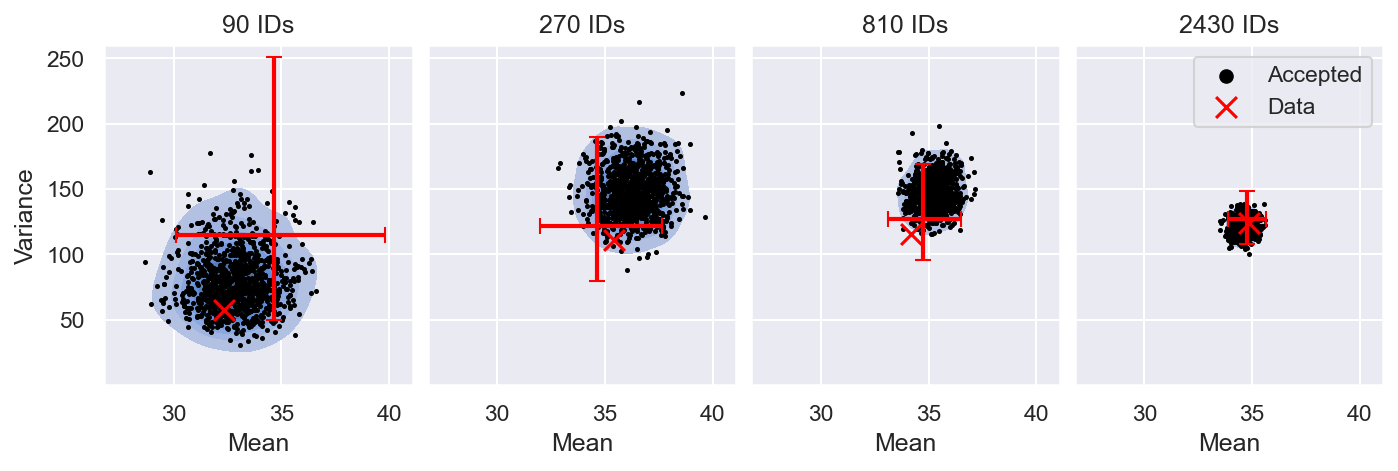

In [125]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 600 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 4, wspace=0.05)

# Create axis for data
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[3]))
axes[0].sharex(axes[1])
axes[1].sharex(axes[2])
axes[2].sharex(axes[3])

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

axes[3].scatter(
        [33], [1000], color='black', label='Accepted')
for idx, ax in enumerate(axes):
    # Plot accepted means and variances
    sns.kdeplot(
        x=inference_summary_stats[idx][0], y=inference_summary_stats[idx][1],
        ax=ax, bw_adjust=1.5, fill=True)
    ax.scatter(
        inference_summary_stats[idx][0], inference_summary_stats[idx][1],
        s=2, color='black')

    # Plot data mean and variance
    axes[idx].errorbar(
        x=[errors[idx, 0]], y=[errors[idx, 3]],
        xerr=errors[idx, 1:3],
        yerr=errors[idx, 4:],
        capsize=4,
        elinewidth=2, marker=None, color='red')
    axes[idx].scatter(
        [data_summary_stats[idx][0]], [data_summary_stats[idx][1]],
        marker='x', color='red', label='Data', s=100)

# Labelling
axes[0].set_xlabel('Mean')
axes[1].set_xlabel('Mean')
axes[2].set_xlabel('Mean')
axes[3].set_xlabel('Mean')
axes[0].set_ylabel('Variance')
axes[0].set_ylim([0.25, 260])
axes[1].set_ylim([0.25, 260])
axes[2].set_ylim([0.25, 260])
axes[3].set_ylim([0.25, 260])
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])
axes[3].set_yticklabels([])
axes[0].set_title('90 IDs')
axes[1].set_title('270 IDs')
axes[2].set_title('810 IDs')
axes[3].set_title('2430 IDs')
axes[3].legend()

directory = os.getcwd()
plt.savefig(
    directory + '/03_relationship_to_standard_abc.tif',
    bbox_inches='tight')
plt.savefig(
    directory + '/03_relationship_to_standard_abc.pdf',
    bbox_inches='tight')

plt.show()